In [59]:
 import warnings
warnings.filterwarnings('ignore')


In [60]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [61]:
start = -7
end = 7
n = 300
batch_size = 16

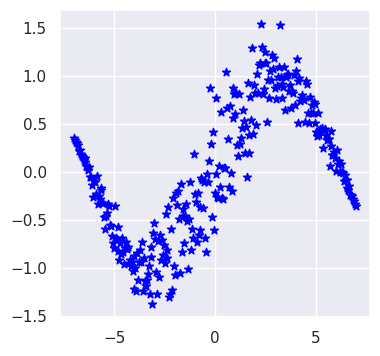

In [62]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

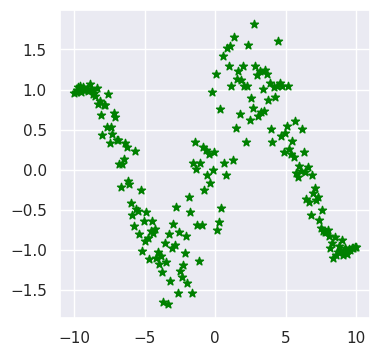

In [63]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

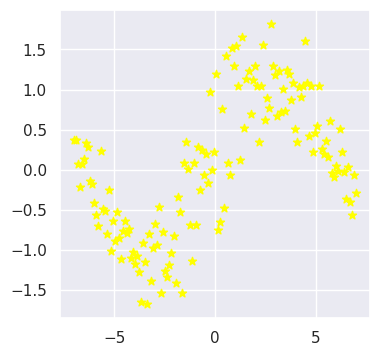

In [64]:
#Plotting In Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask =  (x_test >= -7) &  (x_test <= 7) # Select the ranges -10 to -7 and 7 to 10
x_test_idd = x_test[mask]
y_test_idd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_idd, y_test_idd, c="yellow", marker="*")

plt.show()


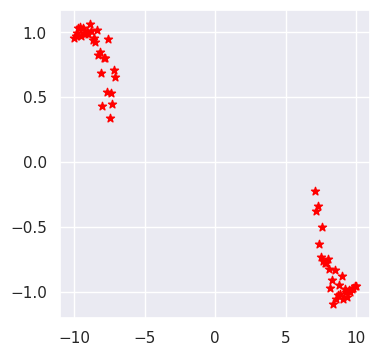

In [65]:
#Plotting Out of Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask = (x_test >= -10) & (x_test < -7) | (x_test > 7) & (x_test <= 10) # Select the ranges -10 to -7 and 7 to 10
x_test_oodd = x_test[mask]
y_test_oodd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_oodd, y_test_oodd, c="red", marker="*")

plt.show()


In [66]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Test for OODD (Out of Data Distribution)
tensor_x_test_oodd = torch.Tensor(x_test_oodd).unsqueeze(1)
tensor_y_test_oodd = torch.Tensor(y_test_oodd).unsqueeze(1)
test_dataset_oodd = TensorDataset(tensor_x_test_oodd, tensor_y_test_oodd)
test_loader_oodd = DataLoader(test_dataset_oodd, batch_size=batch_size, shuffle=True)

#Test for IDD (In Data Distribution)
tensor_x_test_idd = torch.Tensor(x_test_idd).unsqueeze(1)
tensor_y_test_idd = torch.Tensor(y_test_idd).unsqueeze(1)
test_dataset_idd = TensorDataset(tensor_x_test_idd, tensor_y_test_idd)
test_loader_idd = DataLoader(test_dataset_idd, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [67]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        hidden_size = 60

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, 1)
        self.var = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.tanh(self.fc1(x))
        h = torch.tanh(self.fc2(h))
        mu = self.mu(h)
        # Exponential activation to enforce positive var
        # Arash: this might be a significant difference:
        var = torch.exp(self.var(h))
        return mu, var



In [68]:

sns.set(rc={'figure.figsize':(4, 4)})

def make_plot(model):
    # Get predictions
    mu, var = model(tensor_x_test)
    mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.5)
    plt.show()

In [69]:
#PLOTTING IN DATA DISTRIBUTION
sns.set(rc={'figure.figsize':(4, 4)})

def make_plot_idd(model):
    # Get predictions
    mu, var = model(tensor_x_test_idd)
    mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test_idd.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_idd, y_test_idd, c="yellow", marker="*", alpha=0.5)
    plt.show()

In [70]:
#PLOTTING OUT OF DATA DISTRIBUTION
sns.set(rc={'figure.figsize':(4, 4)})

def make_plot_oodd(model):
    # Get predictions
    mu, var = model(tensor_x_test_oodd)
    mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test_oodd.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_oodd, y_test_oodd, c="red", marker="*", alpha=0.5)
    plt.show()

In [71]:
net = SimpleNet()
print(net)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

SimpleNet(
  (fc1): Linear(in_features=1, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=60, bias=True)
  (mu): Linear(in_features=60, out_features=1, bias=True)
  (var): Linear(in_features=60, out_features=1, bias=True)
)
Params: 3902


In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Loss expects mean, variance and target
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [73]:
net.train()
net.to(device)

SimpleNet(
  (fc1): Linear(in_features=1, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=60, bias=True)
  (mu): Linear(in_features=60, out_features=1, bias=True)
  (var): Linear(in_features=60, out_features=1, bias=True)
)

In [74]:
def MLE_snn():
  net=SimpleNet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


In [75]:
def MLE_snn_idd():
  net=SimpleNet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_idd:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)

  make_plot_idd(net)

  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


In [76]:
def MLE_snn_oodd():
  net=SimpleNet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_oodd:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot_oodd(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


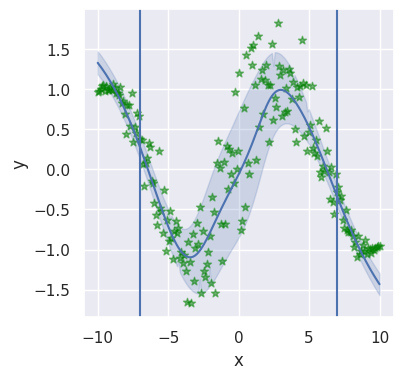

Epoch 149 | batch train loss: -1.2039473056793213 | test loss: 0.19042770564556122
Epoch 149 |batch train mse:0.06957077234983444| test mse:0.1470042077394632


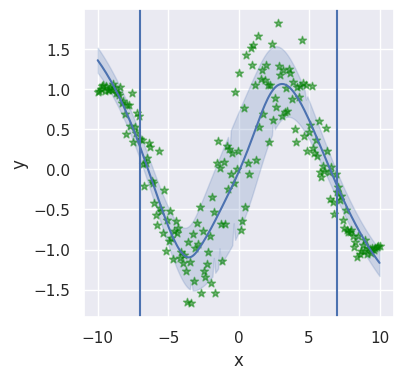

Epoch 149 | batch train loss: -1.2736033201217651 | test loss: 0.2023053146325625
Epoch 149 |batch train mse:0.05149558559060097| test mse:0.15008404922599977


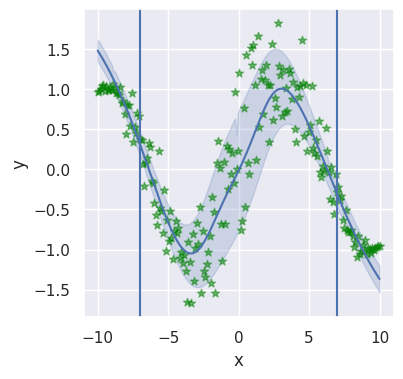

Epoch 149 | batch train loss: -1.0100362300872803 | test loss: 1.116920347397144
Epoch 149 |batch train mse:0.07786823064088821| test mse:0.16423936704030404


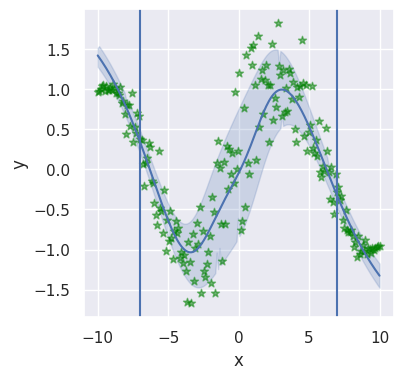

Epoch 149 | batch train loss: -1.203330636024475 | test loss: 0.16605310657849678
Epoch 149 |batch train mse:0.031212039291858673| test mse:0.1446573410469752


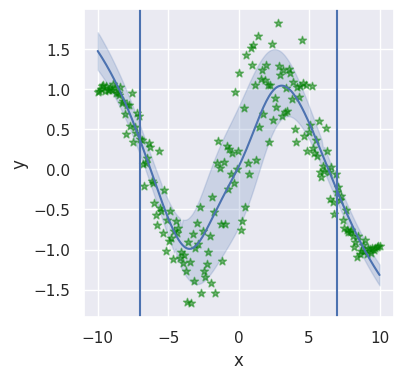

Epoch 149 | batch train loss: -0.9322087168693542 | test loss: 0.14589502203923005
Epoch 149 |batch train mse:0.08038841933012009| test mse:0.13926263497425959


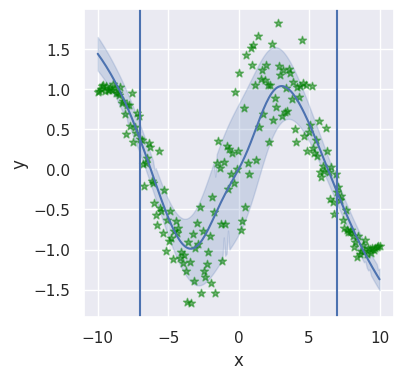

Epoch 149 | batch train loss: -1.1569820642471313 | test loss: 0.17884296751939333
Epoch 149 |batch train mse:0.06478558480739594| test mse:0.1373197344633249


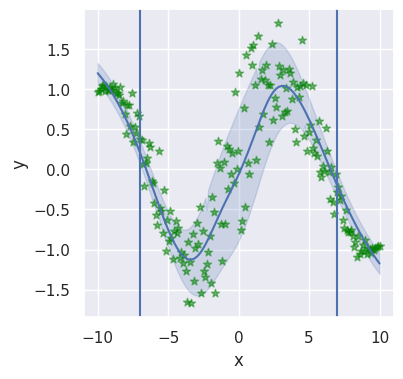

Epoch 149 | batch train loss: -0.6803936958312988 | test loss: 0.32388878900271195
Epoch 149 |batch train mse:0.11167826503515244| test mse:0.147422209668618


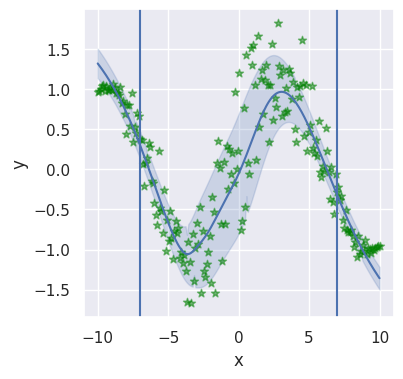

Epoch 149 | batch train loss: -0.8357105255126953 | test loss: 0.20843414733043084
Epoch 149 |batch train mse:0.14530184864997864| test mse:0.14145866695504922


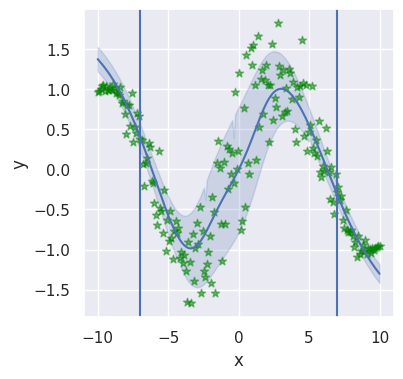

Epoch 149 | batch train loss: -1.524082064628601 | test loss: 0.2838126357931357
Epoch 149 |batch train mse:0.026877673342823982| test mse:0.14915524509090644


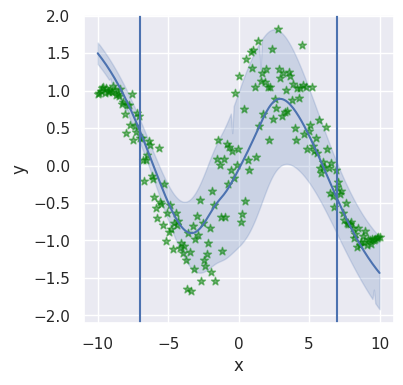

Epoch 149 | batch train loss: -0.6690824031829834 | test loss: 0.6178529205230566
Epoch 149 |batch train mse:0.10085716098546982| test mse:0.15040754440885323


In [77]:
train_losses=[]
test_losses=[]
errors_train=[]
errors_test=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_snn()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)
  errors_train.append(mse_tr)
  errors_test.append(mse_test)

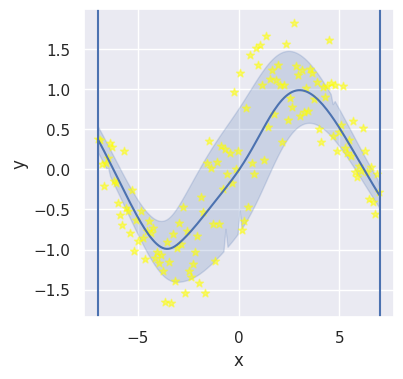

Epoch 149 | batch train loss: -1.4833680391311646 | test loss: 0.505603589117527
Epoch 149 |batch train mse:0.03658037260174751| test mse:0.19192207273509768


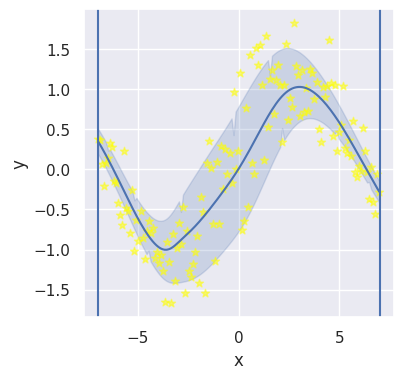

Epoch 149 | batch train loss: -1.199504017829895 | test loss: 1.2938623974720638
Epoch 149 |batch train mse:0.06751274317502975| test mse:0.21865139404932657


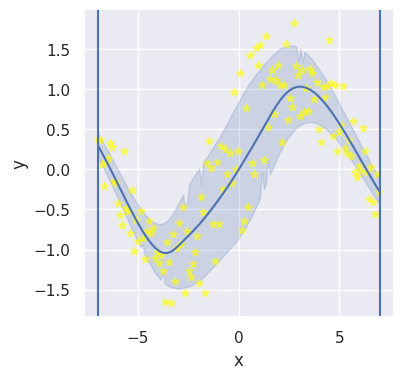

Epoch 149 | batch train loss: -1.3541072607040405 | test loss: 0.5581213633219401
Epoch 149 |batch train mse:0.04585447534918785| test mse:0.19122138453854454


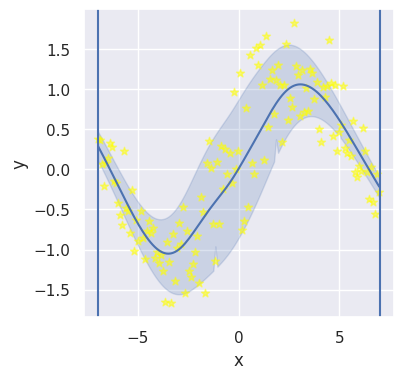

Epoch 149 | batch train loss: -1.180201530456543 | test loss: 0.691479378276401
Epoch 149 |batch train mse:0.02973603457212448| test mse:0.19030113435453838


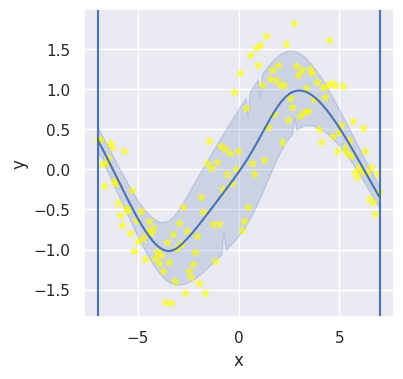

Epoch 149 | batch train loss: -1.5253373384475708 | test loss: 0.539393232928382
Epoch 149 |batch train mse:0.01266713347285986| test mse:0.1922317999932501


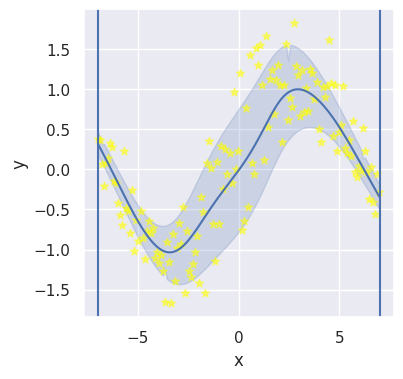

Epoch 149 | batch train loss: -1.0809462070465088 | test loss: 0.46434446589814293
Epoch 149 |batch train mse:0.057146068662405014| test mse:0.18749843455023235


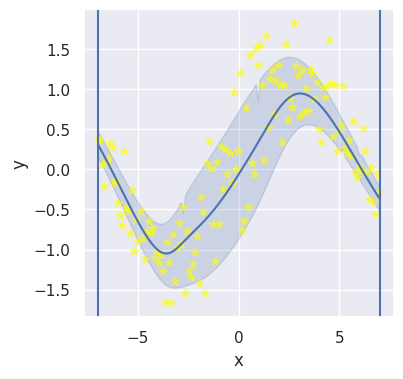

Epoch 149 | batch train loss: -1.537122368812561 | test loss: 0.7759072474307485
Epoch 149 |batch train mse:0.030742758885025978| test mse:0.2090753573510382


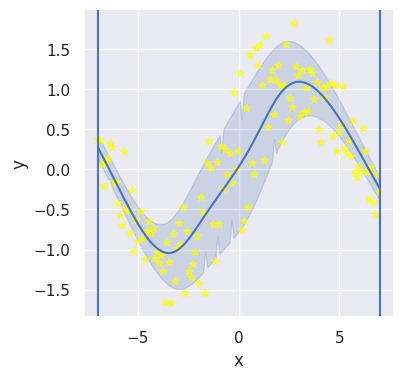

Epoch 149 | batch train loss: -1.1959680318832397 | test loss: 0.5116733304328389
Epoch 149 |batch train mse:0.06473973393440247| test mse:0.19159255093998379


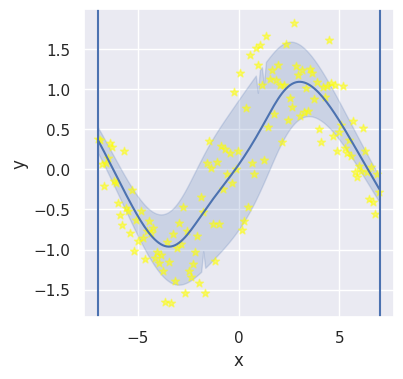

Epoch 149 | batch train loss: -1.4062036275863647 | test loss: 0.5088723968300555
Epoch 149 |batch train mse:0.032614730298519135| test mse:0.18626002884573406


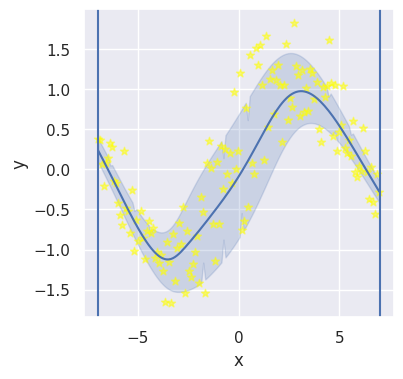

Epoch 149 | batch train loss: -1.2593297958374023 | test loss: 0.5219536821047465
Epoch 149 |batch train mse:0.0625133290886879| test mse:0.19169845514827305


In [78]:
train_losses_idd=[]
test_losses_idd=[]
errors_train_idd=[]
errors_test_idd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_snn_idd()
  train_losses_idd.append(tr_loss)
  test_losses_idd.append(test_loss)
  errors_train_idd.append(mse_tr)
  errors_test_idd.append(mse_test)

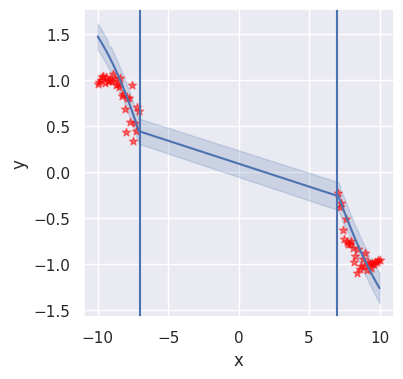

Epoch 149 | batch train loss: -1.3539265394210815 | test loss: -0.41730721294879913
Epoch 149 |batch train mse:0.06393244117498398| test mse:0.03900127299129963


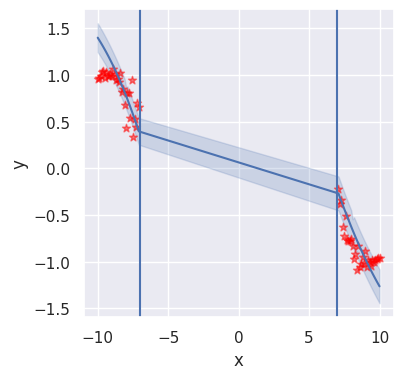

Epoch 149 | batch train loss: -1.5618330240249634 | test loss: -0.4698195271193981
Epoch 149 |batch train mse:0.03155268356204033| test mse:0.03665531054139137


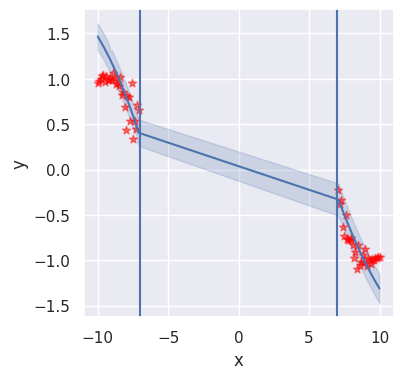

Epoch 149 | batch train loss: -1.495906949043274 | test loss: 0.2555130757391453
Epoch 149 |batch train mse:0.037041712552309036| test mse:0.05116196162998676


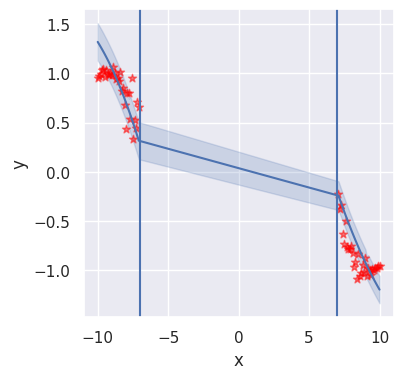

Epoch 149 | batch train loss: -1.334603190422058 | test loss: 0.3201151676476002
Epoch 149 |batch train mse:0.03352593258023262| test mse:0.052454001270234585


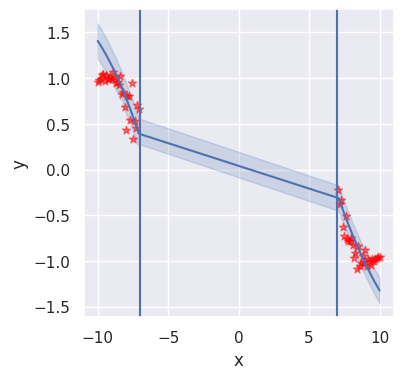

Epoch 149 | batch train loss: -1.3494526147842407 | test loss: 0.882541736587882
Epoch 149 |batch train mse:0.04228108003735542| test mse:0.06465509720146656


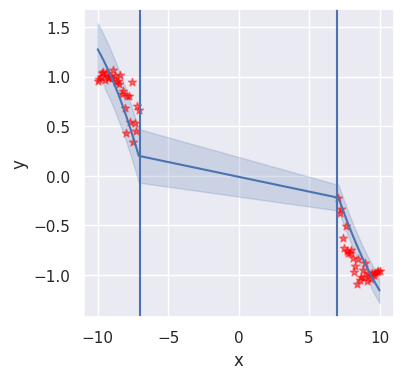

Epoch 149 | batch train loss: -0.808002233505249 | test loss: -0.3931013494729996
Epoch 149 |batch train mse:0.0735534206032753| test mse:0.038189676590263844


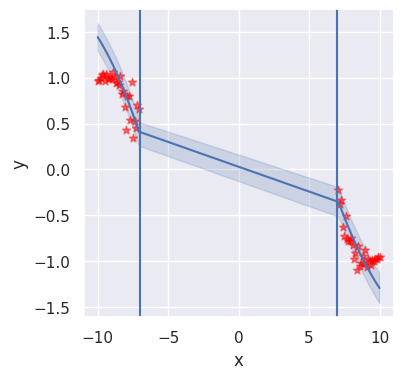

Epoch 149 | batch train loss: -1.5767205953598022 | test loss: -0.23373860120773315
Epoch 149 |batch train mse:0.01558267418295145| test mse:0.041376929730176926


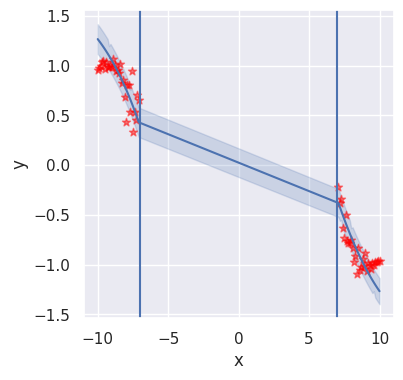

Epoch 149 | batch train loss: -1.0296599864959717 | test loss: -0.9718131124973297
Epoch 149 |batch train mse:0.06670630723237991| test mse:0.02661543758586049


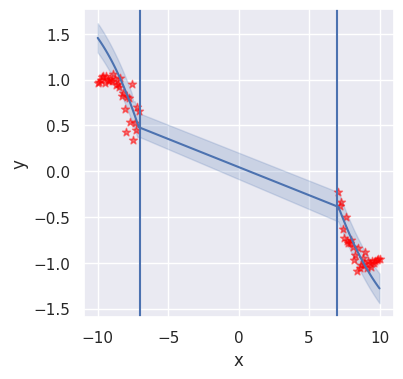

Epoch 149 | batch train loss: -1.1027675867080688 | test loss: -0.1886138580739498
Epoch 149 |batch train mse:0.07835180312395096| test mse:0.04227942414581776


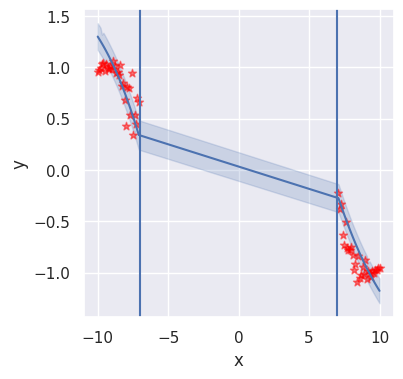

Epoch 149 | batch train loss: -1.141482949256897 | test loss: -0.5907001979649067
Epoch 149 |batch train mse:0.09426763653755188| test mse:0.034237696789205074


In [79]:
train_losses_oodd=[]
test_losses_oodd=[]
errors_train_oodd=[]
errors_test_oodd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_snn_oodd()
  train_losses_oodd.append(tr_loss)
  test_losses_oodd.append(test_loss)
  errors_train_oodd.append(mse_tr)
  errors_test_oodd.append(mse_test)

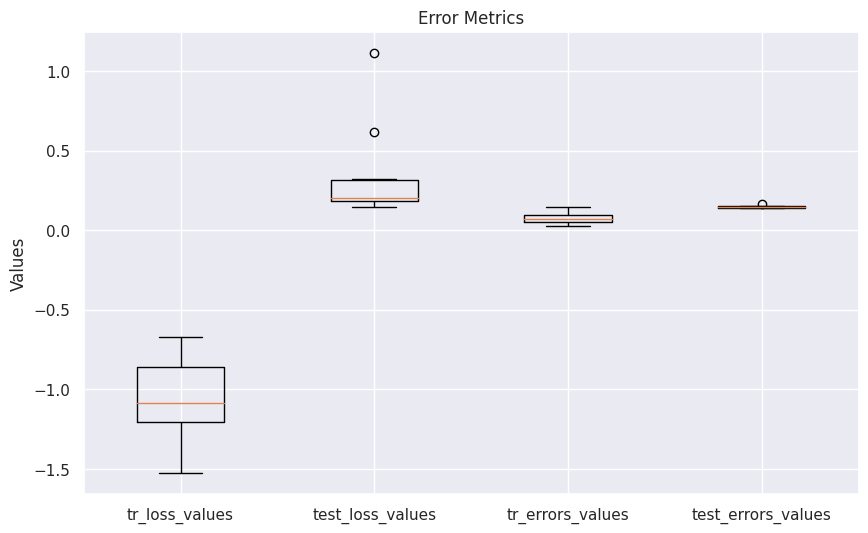

In [80]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= [tensor.item() for tensor in train_losses]
test_loss_values=test_losses
tr_errors_values= [tensor.item() for tensor in errors_train]
test_errors_values= errors_test

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values, tr_errors_values, test_errors_values]
box_labels = ['tr_loss_values', 'test_loss_values', 'tr_errors_values', 'test_errors_values']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metrics')

# Show the plot
plt.show()


In [81]:

mean_gaus_train_loss = np.mean(tr_loss_values)
std_dev_gaus_train_loss = np.std(tr_loss_values)

mean_gaus_test_loss = np.mean(test_loss_values)
std_dev_gaus_test_loss = np.std(test_loss_values)

mean_mse_train = np.mean(tr_errors_values)
std_dev_mse_train = np.std(tr_errors_values)

mean_mse_test = np.mean(test_errors_values)
std_dev_mse_test = np.std(test_errors_values)

print('Mean of Gausiann Training Loss of 10 runs ', mean_gaus_train_loss)
print('Standard Deviation of Gausiann Training Loss of 10 runs ' , std_dev_gaus_train_loss )

print('Mean of Gausiann Testing Loss of 10 runs ',mean_gaus_test_loss )
print('Standard Deviation of Gausiann Testing Loss of 10 runs ',std_dev_gaus_test_loss)

print('Mean of MSE Training of 10 runs ',mean_mse_train)
print('Standard Deviation of MSE Training of 10 runs ' , std_dev_mse_train)

print('Mean of MSE Testing of 10 runs ',mean_mse_test )
print('Standard Deviation of MSE Testing of 10 runs ', std_dev_mse_test)

Mean of Gausiann Training Loss of 10 runs  -1.0489376962184906
Standard Deviation of Gausiann Training Loss of 10 runs  0.2600951915411481
Mean of Gausiann Testing Loss of 10 runs  0.34344329564617226
Standard Deviation of Gausiann Testing Loss of 10 runs  0.2892494813018327
Mean of MSE Training of 10 runs  0.07600355800241232
Standard Deviation of MSE Training of 10 runs  0.03450049341716296
Mean of MSE Testing of 10 runs  0.1471011000613754
Standard Deviation of MSE Testing of 10 runs  0.007161064331867717


In [82]:
# Create a DataFrame from the lists
data = {
    'Training Loss': tr_loss_values,
    'Testing Loss': test_loss_values,
    'Mean Squared Training Error': tr_errors_values,
    'Mean Squared Testing Error': test_errors_values
}

num_columns = len(data)

column_names = ['Training Loss','Testing Loss', 'Mean Squared Training Error','Mean Squared Testing Error']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)
df.to_csv('results_snn.csv', index=True)

    Training Loss  Testing Loss  Mean Squared Training Error  \
1       -1.203947      0.190428                     0.069571   
2       -1.273603      0.202305                     0.051496   
3       -1.010036      1.116920                     0.077868   
4       -1.203331      0.166053                     0.031212   
5       -0.932209      0.145895                     0.080388   
6       -1.156982      0.178843                     0.064786   
7       -0.680394      0.323889                     0.111678   
8       -0.835711      0.208434                     0.145302   
9       -1.524082      0.283813                     0.026878   
10      -0.669082      0.617853                     0.100857   

    Mean Squared Testing Error  
1                     0.147004  
2                     0.150084  
3                     0.164239  
4                     0.144657  
5                     0.139263  
6                     0.137320  
7                     0.147422  
8                     0.141459 

In [83]:
print(test_errors_values)

[0.1470042077394632, 0.15008404922599977, 0.16423936704030404, 0.1446573410469752, 0.13926263497425959, 0.1373197344633249, 0.147422209668618, 0.14145866695504922, 0.14915524509090644, 0.15040754440885323]
